## Introduction

As I type this blog post/repository on Dec 31st 2020, I reflect back on the year that was. After graduation, my focus after a short (long) stay-at-home vacation was to start building skills in different areas. One area of focus is to develop my learning and understanding of the tools that are available in the data science and machine learning realms. My focus is rather scattered between different sports and esports titles, but with all of this practice, I realized how much depth there is just on the surface level. Each respository took me down one rabbit hole after another, making me realize how much there is to learn. After going through small-projects about [League of Legends](https://github.com/inm2/Damwon-Analysis) and [College Football](https://github.com/inm2/Random-Forest-College-Football/blob/main/Random%20Forest%20Classifier.ipynb), in a year that I can mark personal progression, with the year coming to an end, I want to analyze data on myself.

Specifically, I want to track my progress through the FPS training tool, AimLab. Starting at the beginning of December, I spent each day practicing for 30 minutes in the six major categories AimLab has set: Flicking, Tracking, Perception, Cognition, Precision, and Speed. [This video](https://www.youtube.com/watch?v=WWcTnGX8yyQ) goes into more depth into each different training mode. Each training category has specific parameters that factor into the final score, which is summed with previous training scores, averaged, and turned into a rating. The higher the rating, the better you are at a specific tasks. 

For example, parameters for Flicking, Precision, and Speed for the Spiderbot mode:
- Accuracy (%): The percentages of how many times you hit targets on the grid compared to the amount missed.
- Reaction Time (milliseconds): The time taken to hit a target.  
- Targets per Second aka TPS: The amount of targets hit per second.  
- Score: The total score, influenced by the parameters listed above.  

After exporting my data from AimLab after Day 20, an example of my progress in the Flicking category is shown below. Using the trendlines, I have a steady rate of improvement across TPS and Accuracy. My reaction time is going down, indicating that the more I practice, the more I improve. Each practice is 1 minute long, so if I practice twice per day in each category, I have 40 minutes of practice/category at the Day 20 mark. In some cases, I practiced more than twice if I felt I was lacking in a specific area. 

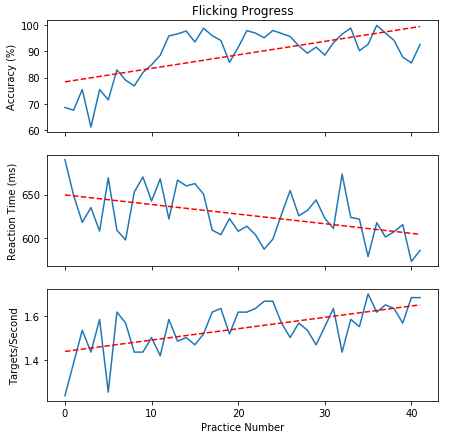

In [3]:
#Flicking Charts
from IPython.display import Image
Image(r'Flicking Progress.png') 

## Forecasting Scores - Speed

After seeing my improvements, I wanted to see what my future scores would look like. 

To do this, I used an Autoregressive Integrated Moving Average (ARIMA) model. Avoiding redundancy, I used the Speed category for this analysis. 

Note: [I used Susan Li's ARIMA tutorial for this project.](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

In [4]:
#Importing Libraries
import warnings 
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns

#Standardizing text for graphs
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

First, I imported a table from AimLab. Most of everything I will need for the analysis is already available for scoring. Unfortunately, the score isn't. Using the in-game line chart, I added in the scores to the corresponding practice date, labeled as 'Scores'.

I will use the other parameters later in the project.

In [20]:
#Reading in tables, then filtering scores
#Read in table and then filter scores
speed = pd.read_csv(r'Speed Filtering.csv')
scores = speed['Scores']

#Showing the contents of speed
speed.tail()

,createDate,taskName,mode,weaponName,map,version,accTotal,accB0,accB1,accB2,...,rtB6,rtB7,targetsTotal,shotsTotal,killsPerSec,killTotal,Scores,Count,mavg,truescore
41,12/27/2020 1:30,spidershot,12,9mm,0,NaN,86.538470,94,89,94,...,402.087410,468.750193,148,156,2.253463,135,63525,42,59907.33333,59.907333
42,12/27/2020 1:31,spidershot,12,9mm,0,NaN,86.986305,100,95,84,...,634.531289,451.179916,138,146,2.120012,127,58686,43,60154.00000,60.154000
43,12/27/2020 22:11,spidershot,12,9mm,0,NaN,83.006540,95,72,81,...,412.407467,390.176359,140,153,2.119917,127,58218,44,60143.00000,60.143000
44,12/27/2020 22:12,spidershot,12,9mm,0,NaN,84.868416,95,89,87,...,524.413511,456.677893,146,152,2.153351,129,60720,45,59208.00000,59.208000
45,12/27/2020 22:13,spidershot,12,9mm,0,NaN,85.987270,88,77,79,...,459.352794,369.377692,150,157,2.253466,135,63607,46,60848.33333,60.848333


Next, I plot the chart of the scores. From the first practice session to the last, my scores have increased. 

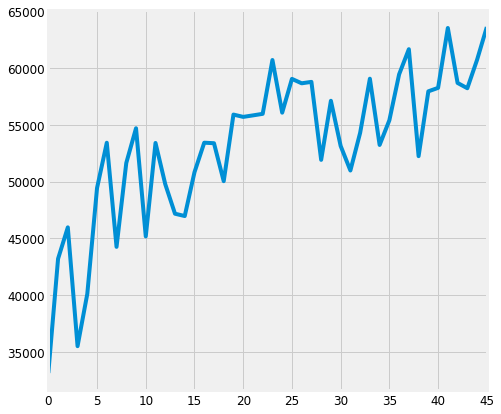

In [7]:
#plotting scores
scores.plot(figsize=(7,7))
plt.show()

## Forecasting with ARIMA

The ARIMA model is a class of three different aspects:

[Source 1](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)  
[Source 2](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/)

- Autoregression (AR): A time-series model that takes previous time steps of an input, x, to predict future values. It models the relationship between an input and it's lagged observations.   
- Integration/Integrated (I): Takes the difference of raw observations in order for the data to become stationary.  
- Moving Average (MA): A series of averages at different points in the data. For example, the MA at point one is different than the MA at point 3, given the scores for each entry are not equal. 

Each parameter of the model is represented by:
- p: The number of lagged observations in the model
- d: The number of times the raw observations are differenced  
- q: The size of the moving average

Since the Speed score graph shows a trend, differencing the scores will be needed to make it stationary. To do so, a list of parameters are created using p, d, and q. The SARIMA (S = season) model is implemented to create a grid search to find the most optimal parameters to fit into the ARIMA model.

In SARIMA, the seasonal elements not represented in the default ARIMA model are:
- P: seasonal autogregressive order
- D: seasonal difference order
- Q: seasonal moving average order
- m: Number of time steps for a single seasonal period  

Combining the original ARIMA model parameters, the SARIMA model is defined as:  
(1) (p,d,q)x(P,D,Q)m, where (p,d,q) = order, and (P,D,Q)m = seasonal order.   

Using the SARIMAX function, the list defined by (1) is traversed. The Akaike information criterion (AIC) is the output, and estimates the quality of each model when compared to the remaining models.  

A grid search is performed to find the most optimal value of AIC. The lowest value is considered to be most optimal. 

In [11]:
warnings.filterwarnings("ignore")
#Figure out AIC number - 369.5 in this case for scores
#Using first order differential, lag, and moving average size
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
list(itertools.product(p,d,q))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(scores,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1110.3947785971563
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1373.3147029138677
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:678.5063345200223
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:428.17832242386424
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:694.168437911299
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:674.8530954598933
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:448.22527729163124
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:426.73595465149236
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1058.3144193023243
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:25029.284927029046
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:649.3289689112516
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:398.06267296526437
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:810.7309225575698
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:765.4058967207666
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:439.0874911618658
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:398.58933919000094
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:874.9751948678224
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1128.4154599924793
A

Taking the minimum of the AIC values in the list, 369.5, the order is defined as p = d = q = 1, or (1,1,1), and the seasonal order is input as (P,D,Q,m) = (1,1,1,12).

In [15]:
#Figuring out minimum AIC
minElement = np.amin(results.aic)
print(minElement)

369.50673889842415


## Devloping (S)ARIMA model

Next, using the order and seasonal order from the previous step, the model is created. 

Results.summary() shows the z-test, which is used to determine if two population means are different when variances are known and the population size is large. The use of this test is to see if the features of the model are comparable to a random sample from the population (null hypothesis). The z-score, or z, is taken from the difference between the sample and population mean and divided by the standard error, represented by std err. The p-value is compared to the z-score. In the cases below, the p-values are all higher than the z-score, and greater than the confidence interval of .05, which indicates that there is a failure to reject the null hypothesis. 

Based on the graphs below, the data can be fit into a normal distribution, with a slight skew towards -2, and is auto-correlated.  

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4993      1.599      0.312      0.755      -2.635       3.633
ma.L1         -0.5868      1.497     -0.392      0.695      -3.520       2.346
ar.S.L12       0.0475      0.252      0.188      0.851      -0.447       0.542
ma.S.L12      -0.6528      0.706     -0.925      0.355      -2.037       0.731
sigma2      3.408e+07   4.57e-08   7.47e+14      0.000    3.41e+07    3.41e+07


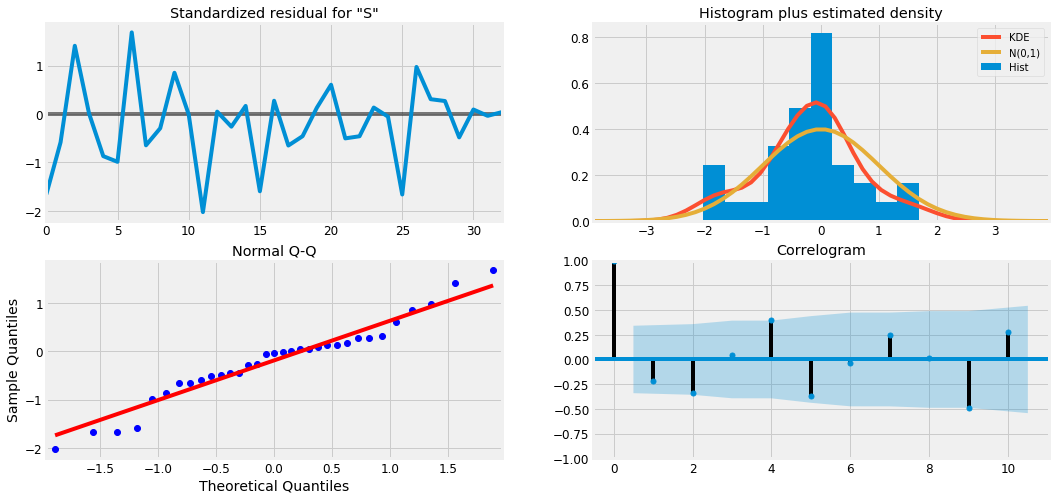

In [21]:
#Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(scores,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_invertibility = False)
results = mod.fit()

print(results.summary().tables[1])

#Show if data is uniformly distributed
results.plot_diagnostics(figsize=(16,8))
plt.show()

## Validating the Data

To show the amount of error within predicting the model, a separate prediction model is made only using the datapoints starting from the 30th practice. The graph is shown below.

To calculate the error, the mean squared error (MSE) and root mean squared error (RSME) are calculated. MSE estimates the average squared difference between estimated and true values. RSME shows how close the predicted value is from the true value. 

Using the RSME, the error is 3500. Using the highest score for reference, 63607, the prediction is off by 5.5% in this interval. Taking the low value in this range, 51000, the prediction is off by 6.8%

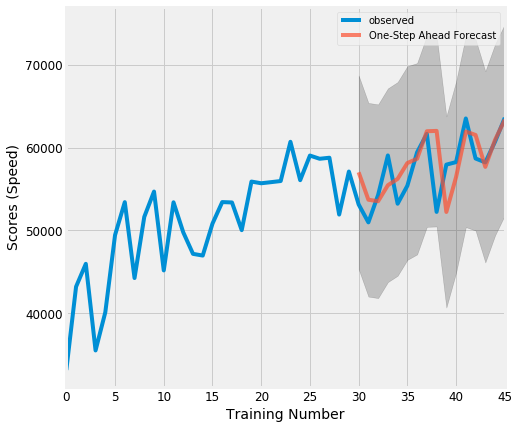

The Mean Squared Error of the forecast is 12252232.84
The Root Mean Squared Error of the forecast is 3500.32


In [23]:
#Validating data
pred = results.get_prediction(start = 30, dynamic=False)
pred_ci = pred.conf_int() #Default confidence interval is .05

ax = scores.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7, figsize=(7,7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha = .2) #This alpha is used to darken confidence interval plot

ax.set_xlabel('Training Number')
ax.set_ylabel('Scores (Speed)')
plt.legend()
plt.show()

scores_forecasted = pred.predicted_mean
scores_truth = scores[30:]

mse = ((scores_forecasted - scores_truth) ** 2).mean()
print('The Mean Squared Error of the forecast is {}'.format(round(mse,2)))

print('The Root Mean Squared Error of the forecast is {}'.format(round(np.sqrt(mse),2)))

## Visualizing the Future

For fun, a model to predict the next 20 instances of practice sessions for Speed training is conducted. As shown by the graph, the prediction assumes that my progress will increase at nearly the same rate as the first 45 practices. 

However, this model overestimates my abilities. 

Currently, I'm on Day 24 of my practice schedule. I'm finding that the difference between the moving averages of each practice session are getting smaller and smaller, indicating that I'm reaching a plateau or small incremental changes in my improvements. If I practiced more and had more data to reflect how my progress is going, I'm sure the predictions will be more accurate.  

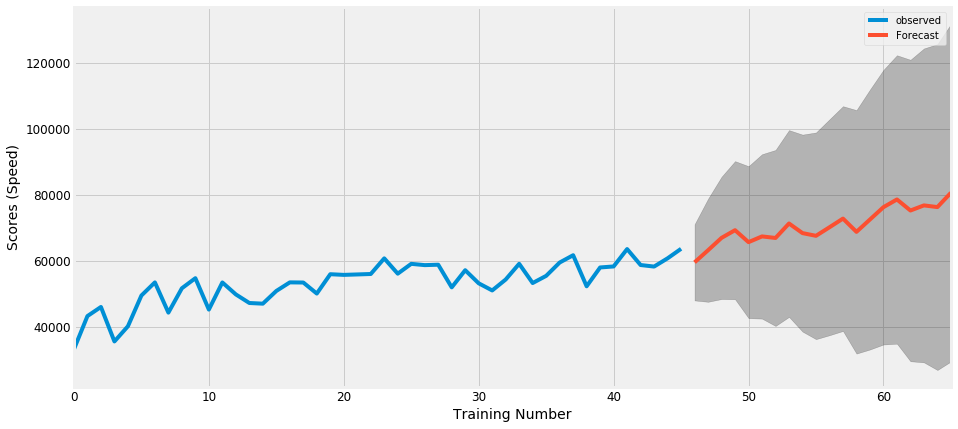

In [18]:
#Visualizing future forecast
pred_uc = results.get_forecast(steps = 20)
pred_ci = pred_uc.conf_int()

ax = scores.plot(label = 'observed', figsize = (14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color = 'k', alpha = .25)
ax.set_xlabel('Training Number')
ax.set_ylabel('Scores (Speed)')

plt.legend()
plt.show()

## What about the other parameters? 

Throughout this project, I've only mentioned the Speed score as the only factor in my analysis. To go more in depth with factors that affect the score, I have made a correlation matrix with the following variables:

- Accuracy (accTotal)  
- Reaction Time (rtTotal)
- Targets per second (killsPerSec)
- Total Targets (targetsTotal): The amount of targets hit in 1 minute
- Target Misses (misses): The amount of targests missed in 1 minute

To show an example of how to variables are related, I also made a correlation analysis between the amount of misses and how it affects scoring. As you can expect, it has a negative correlation, meaning that missing targets will lead to a lower score. This is also reflected in the correlation matrix graph. 

Seeing these variables laid out is quite fascinating. Inferences can easily be made and highlights the factors that contribute to scoring higher: having a low amount of misses, reacting faster to targets, having a high degree of accuracy, and hitting a high amount of targets. Stretch goals can be made to hit a specific amount of targets per second. With visualizing this information, the user can have a more informed idea on what needs to be done to show improvement. 

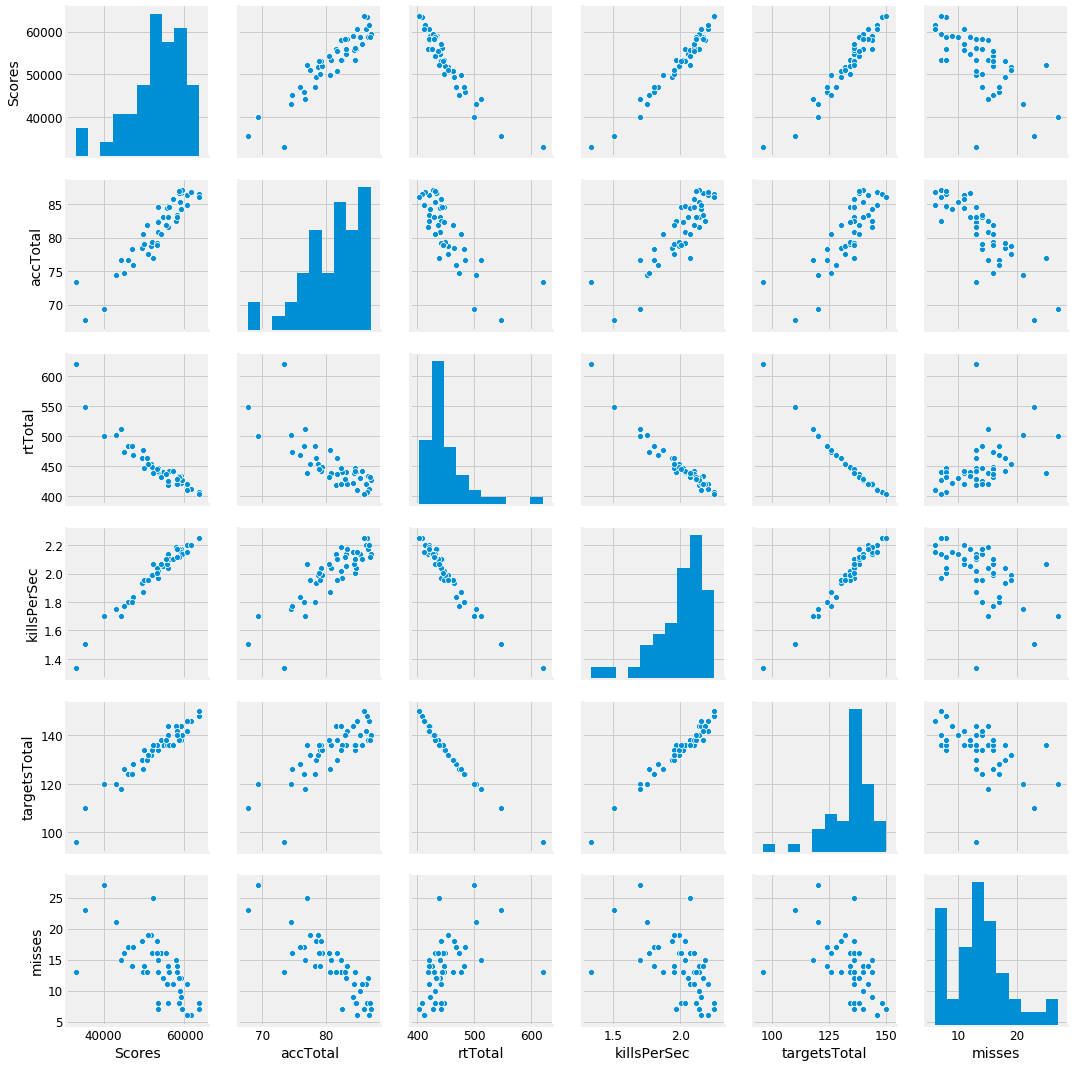

In [31]:
#Making a matrix to show how the relationship between three variables that make up score
#make a new dataframe with variables used for estimations
speed['misses'] = speed['shotsTotal'] - speed['targetsTotal']
df = speed[['Scores', 'accTotal', 'rtTotal', 'killsPerSec', 'targetsTotal', 'misses']]
sns.pairplot(df, kind="scatter")

In [30]:
np.corrcoef(df['Scores'],df['misses'])

array([[ 1.        , -0.65878514],
       [-0.65878514,  1.        ]])

## Conclusion

As a teenager, I can count on one hand the amount of hours I spent playing games like Halo or Call of Duty or Counterstrike. Now as a person converging slowly into a mid-life crisis, I realize how far behind I am in comparision to people that I know who have played for most of their younger years. 

Data analytics has been an interest of mine, and it's definitely useful to learn how to study your own inputs and outputs. If I opened my practice and expanded towards more situational goals and training, depending on the game I wanted to play, it'd be interesting to see how well my improvements translate in-game, on a mechanical level. 

Since the events of 2020 have led to more free time for me, I wanted to grow my skillset and see if I can learn new skills along the way. Turns out, I learned two. 